In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 150}

In [2]:
import numpy as np
import qinfer as qi
import matplotlib.pyplot as plt
plt.style.use('ggplot-rq')

In [3]:
plt.rcParams['savefig.frameon'] = False

## Example: Impovrishment ##

In [40]:
import scipy.stats as stats

In [63]:
stats.norm.pdf([1, 1]).prod()

0.058549831524319168

In [67]:
particles_good = np.random.randn(1200, 2)

particles_bad = np.random.uniform(-4, 4, (400, 2))
wts_bad = np.product(stats.norm.pdf(particles_bad), axis=1)
wts_bad /= wts_bad.sum()

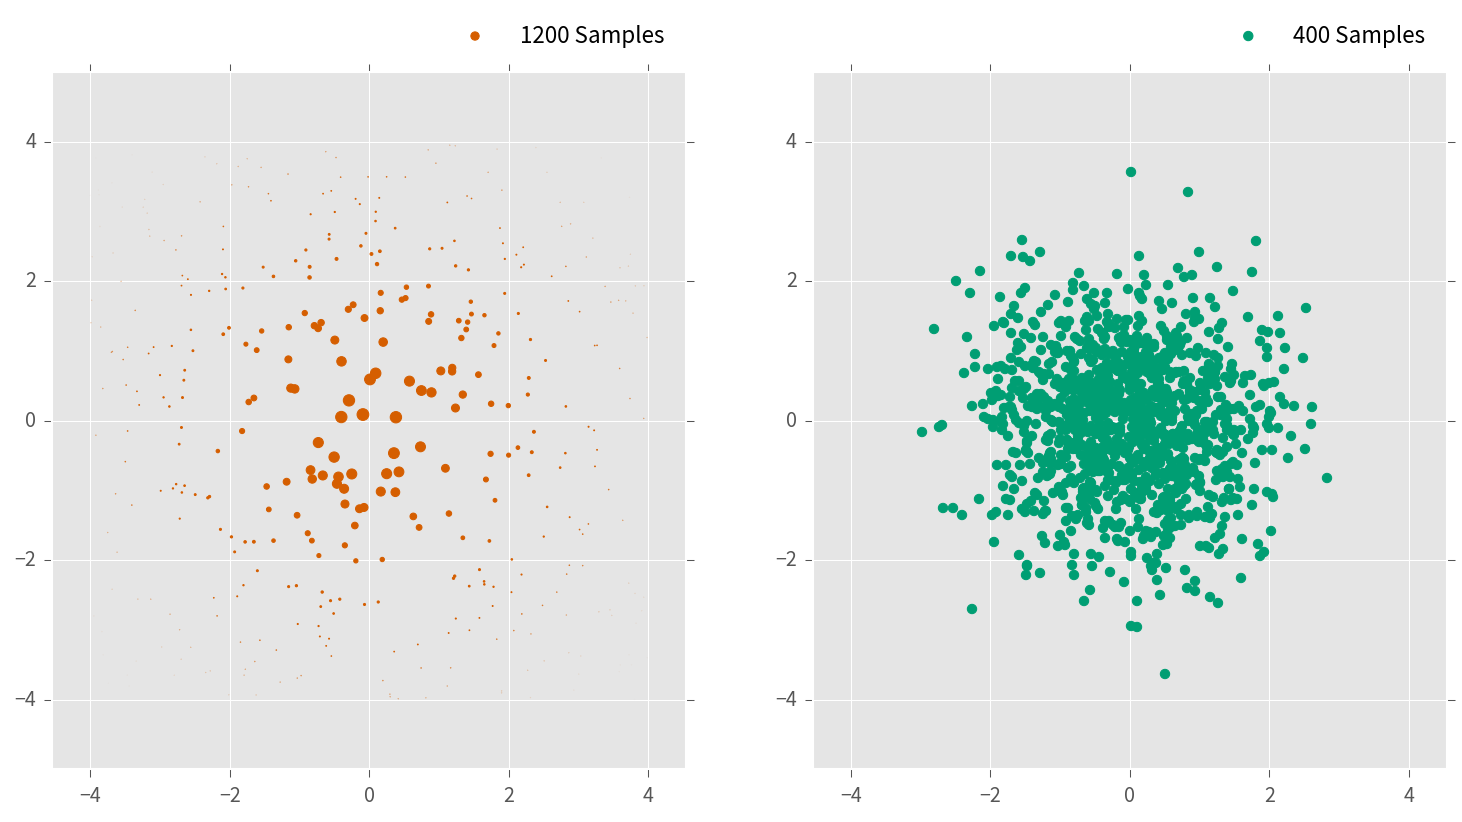

In [84]:
try: style_cycle = plt.rcParams['axes.prop_cycle']()
except:
    from cycler import cycler
    style_cycle = iter(cycler('color', plt.rcParams['axes.color_cycle']))
    
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
plt.scatter(particles_bad[:, 0], particles_bad[:, 1], s=1200 * wts_bad, **style_cycle.next())
plt.legend(['1200 Samples'],bbox_to_anchor=(1, 1.1), scatterpoints=1)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(particles_good[:, 0], particles_good[:, 1], **style_cycle.next())
plt.legend(['400 Samples'],bbox_to_anchor=(1, 1.1), scatterpoints=1)
plt.gca().set_aspect('equal')

plt.savefig('figures/impovrishment.png', format='png', dpi=300, frameon=False, transparent=False)

## Example: Rabi/Ramsey Estimation ##

In [85]:
w = 70.3
w_max = 100.0

ts = np.pi * (1 + np.arange(100)) / (2 * w_max)


ideal_signal = np.sin(w * ts / 2) ** 2

In [86]:
n_shots = 100
counts = np.random.binomial(n=n_shots, p=ideal_signal)

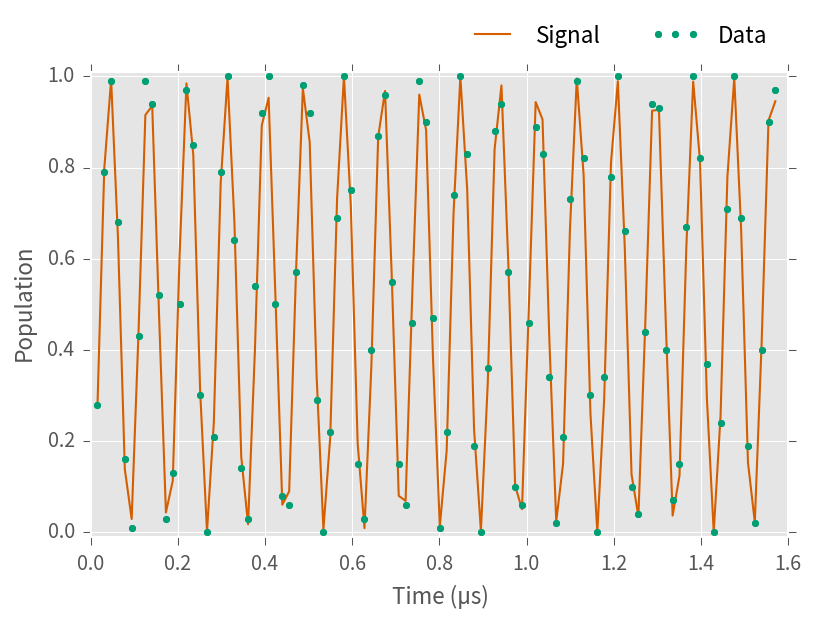

In [87]:
plt.plot(ts, ideal_signal, label='Signal', lw=1)
plt.plot(ts, counts / n_shots, '.', label='Data')
plt.xlabel(u'Time (µs)')
plt.ylabel(r'Population')
plt.ylim(-0.01, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15), numpoints=3)
plt.savefig('figures/rabi-example-signal.png', format='png', dpi=300, frameon=False, transparent=True)

In [88]:
ideal_spectrum = np.abs(np.fft.fftshift(np.fft.fft(ideal_signal - ideal_signal.mean())))**2
spectrum = np.abs(np.fft.fftshift(np.fft.fft((counts - counts.mean()) / n_shots)))**2
ft_freq = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(n=len(counts), d=ts[1] - ts[0]))

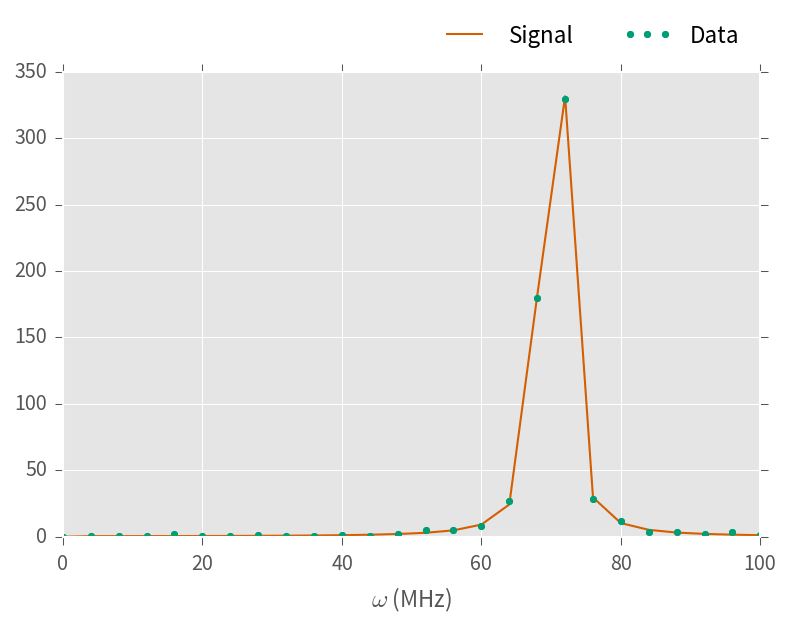

In [89]:
plt.plot(ft_freq, ideal_spectrum, lw=1, label='Signal')
plt.plot(ft_freq, spectrum, '.', label='Data')
ylim = plt.ylim()
# plt.vlines(w, *ylim)
plt.xlim(xmin=0, xmax=100)
# plt.ylim(*ylim)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15), numpoints=3)
plt.xlabel('$\omega$ (MHz)')
plt.savefig('figures/rabi-example-spectrum.png', format='png', dpi=300, frameon=False, transparent=True)

In [90]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

mean, cov, extra = qi.simple_est_prec(data, freq_min=0, freq_max=w_max, return_all=True)
print("Error: {:0.2e}. Estimated error: {:0.2e}.".format(abs(mean - w) / w, np.sqrt(cov) / w))

Error: 2.42e-05. Estimated error: 1.58e-04.


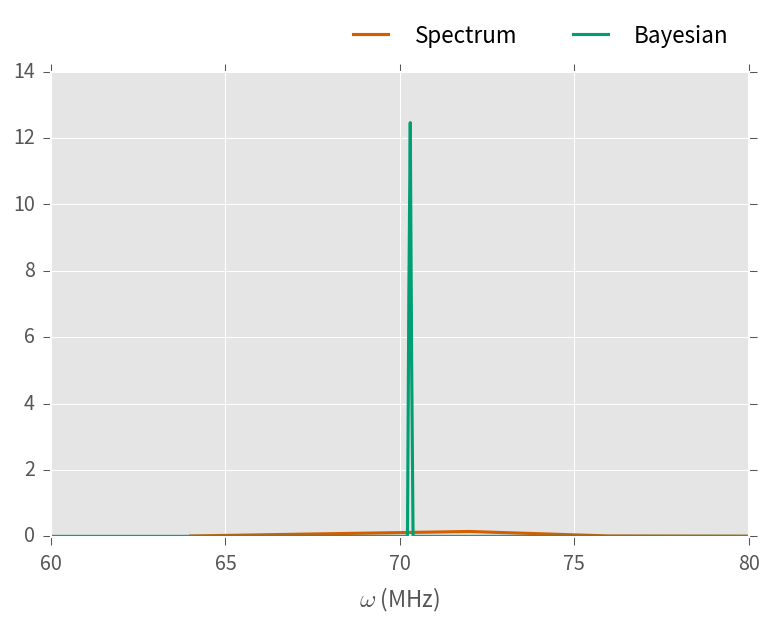

In [92]:
mask = np.logical_and(ft_freq >= 60, ft_freq <= 80)
plt.plot(ft_freq[mask], spectrum[mask] / np.trapz(spectrum[mask], ft_freq[mask]))
xlim = plt.xlim(60, 80)
extra['updater'].plot_posterior_marginal(range_min=xlim[0], range_max=xlim[1], res=500)
plt.xlim(*xlim)
plt.ylim(ymin=-0.01)
plt.xlabel('$\omega$ (MHz)')
plt.legend(['Spectrum', 'Bayesian'], ncol=2, bbox_to_anchor=(1, 1.15))
plt.savefig('figures/rabi-example-posterior.png', format='png', dpi=300, frameon=False, transparent=True)

In [11]:
true_omega = 70.3
omega_min = 0
omega_max = 99.1
n_shots = 100

ts = np.pi * np.arange(1, 101) / (2 * omega_max);

signal = np.sin(true_omega * ts / 2) ** 2;
counts = np.random.binomial(n=n_shots, p=ideal_signal)

data = np.column_stack([counts, ts, n_shots * np.ones(len(ts))])
est = qi.simple_est_prec(data, freq_min=0, freq_max=100)

In [12]:
est

(69.65000898018485, 0.00011791507313319016)

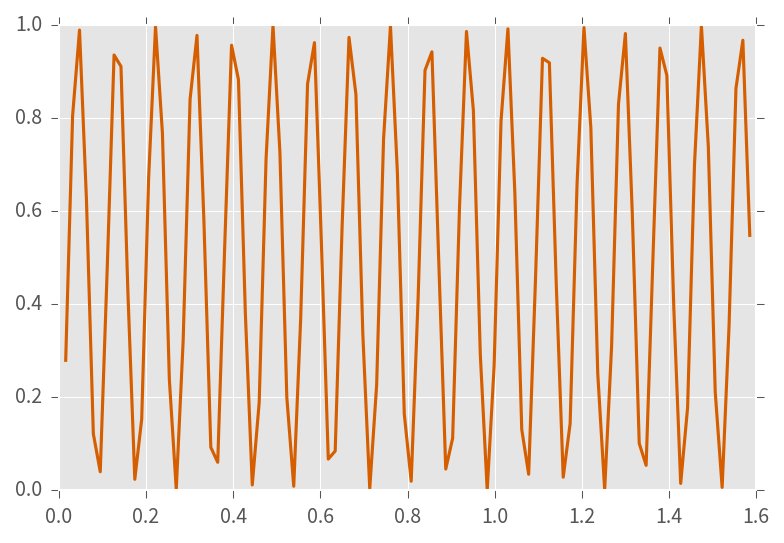

In [13]:
outcomes = np.array([1])
modelparams = np.array([w])
expparams = ts

L = qi.SimplePrecessionModel().likelihood(outcomes, modelparams, expparams)
plt.plot(ts, L[0, 0, :])
plt.savefig('figures/rabi-example-liketens.png', format='png', dpi=300, frameon=False, transparent=True)

In [14]:
from qinfer import *
from functools import partial

In [15]:
performance = perf_test_multiple(
    n_trials=400,
    model=BinomialModel(SimplePrecessionModel()),
    n_particles=2000,
    prior=UniformDistribution([0, 1]),
    n_exp=100,
    heuristic_class=partial(
        ExpSparseHeuristic, t_field='x', other_fields={'n_meas': 40}
    )
)

In [18]:
class UniformSamplingHeuristic(Heuristic):
    def __init__(self,
            updater, dt=np.pi / 2,
            t_field=None, other_fields=None
        ):
        super(UniformSamplingHeuristic, self).__init__(updater)
        self._dt = dt
        self._t_field = t_field
        self._other_fields = other_fields

    def __call__(self):
        n_exps = len(self._updater.data_record)
        t = self._dt * (1 + n_exps)
        dtype = self._updater.model.expparams_dtype

        if self._t_field is None:
            return np.array([t], dtype=dtype)
        else:
            eps = np.empty((1,), dtype=dtype)
            for field, value in self._other_fields.items():
                eps[field] = value
            eps[self._t_field] = t
            return eps

In [49]:
performance_uniform = perf_test_multiple(
    n_trials=400,
    model=BinomialModel(SimplePrecessionModel()),
    n_particles=2000,
    prior=UniformDistribution([0, 1]),
    n_exp=100,
    heuristic_class=partial(
        UniformSamplingHeuristic, t_field='x', other_fields={'n_meas': 40}
    )
)

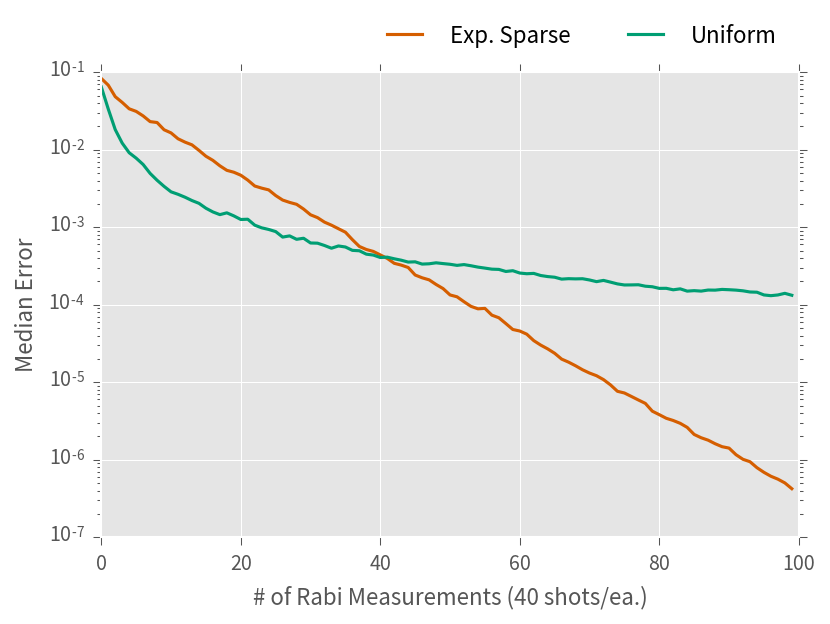

In [50]:
plt.semilogy(np.sqrt(np.median(performance['loss'], axis=0)), label='Exp. Sparse')
plt.semilogy(np.sqrt(np.median(performance_uniform['loss'], axis=0)), label='Uniform')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15))
plt.xlabel('# of Rabi Measurements (40 shots/ea.)')
plt.ylabel('Median Error')
plt.savefig('figures/rabi-performance.png', format='png', dpi=300, frameon=False, transparent=False)

In [51]:
import matplotlib as mpl

In [52]:
def log_formatter(n_digits):
    return mpl.ticker.StrMethodFormatter(
        "$\mathregular{{{{10^{{{{{{x:.{n_digits}f}}}}}}}}}}$".format(n_digits=n_digits)
    )


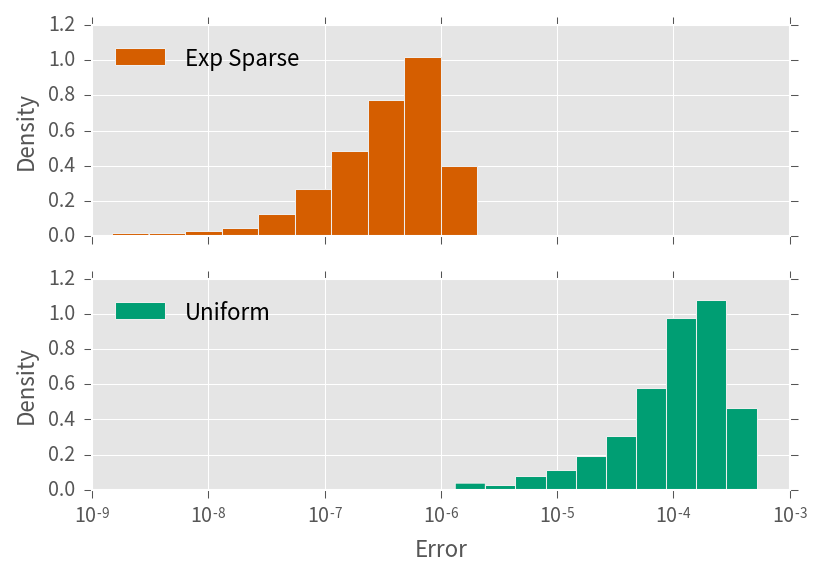

In [54]:
style_cycle = plt.rcParams['axes.prop_cycle']()

ax = plt.subplot(2, 1, 1)
plt.hist(np.log10(np.sqrt(performance['loss'][:, -1])), normed=True, **style_cycle.next())
plt.tick_params(labelbottom='off')
plt.ylabel('Density')
plt.legend(['Exp Sparse'], loc='upper left')

ax = plt.subplot(2, 1, 2, sharex=ax)
plt.hist(np.log10(np.sqrt(performance_uniform['loss'][:, -1])), normed=True, **style_cycle.next())
ax.get_xaxis().set_major_formatter(log_formatter(0))
plt.legend(['Uniform'], loc='upper left')

plt.xlabel('Error')
plt.ylabel('Density')

plt.savefig('figures/rabi-performance-hist.png', format='png', dpi=300, frameon=False, transparent=False)

In [55]:
prior = UniformDistribution([0, 1])
true_params = np.array([[0.5]])
model = RandomWalkModel(BinomialModel(SimplePrecessionModel()), NormalDistribution(0, 0.01**2))
updater = SMCUpdater(model, 2000, prior)

expparams = np.array([(np.pi / 2, 40)], dtype=model.expparams_dtype)

data_record = []
trajectory = []
estimates = []

for idx in range(1000):
    datum = model.simulate_experiment(true_params, expparams)
    true_params = np.clip(model.update_timestep(true_params, expparams)[:, :, 0], 0, 1)
    
    updater.update(datum, expparams)

    data_record.append(datum)
    trajectory.append(true_params[0, 0])
    estimates.append(updater.est_mean()[0])

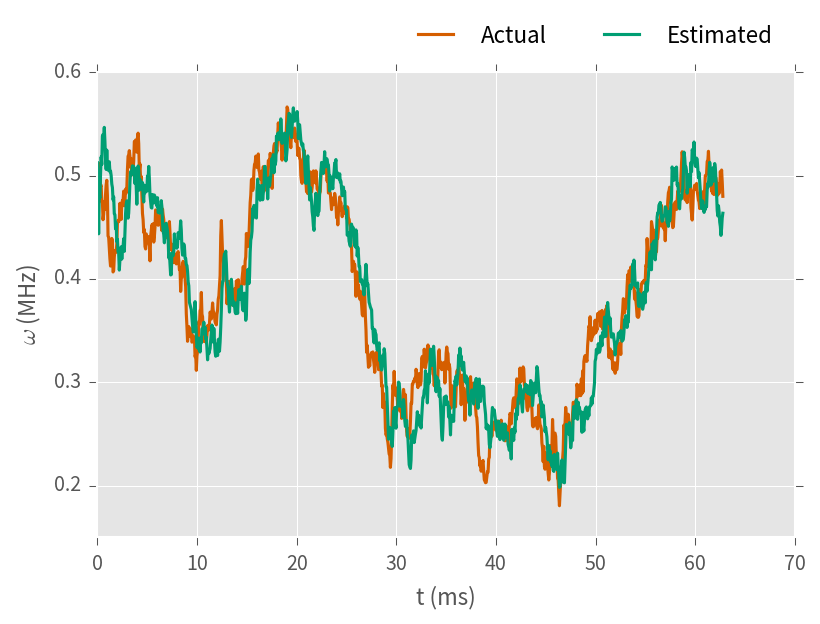

In [56]:
ts = 40 * np.pi / 2 * np.arange(len(data_record)) / 1e3
plt.plot(ts, trajectory, label='Actual')
plt.plot(ts, estimates, label='Estimated')
plt.xlabel(u't (ms)')
plt.ylabel(r'$\omega$ (MHz)')
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15))
plt.savefig('figures/rabi-random-walk.png', format='png', dpi=300, frameon=False, transparent=False)

## RB Example ##

In [86]:
p = 0.995
A = 0.5
B = 0.5

ms = np.linspace(1, 800, 201).astype(int)
signal = A * p ** ms + B

n_shots = 40
counts = np.random.binomial(p=signal, n=n_shots)

data = np.column_stack([counts, ms, n_shots * np.ones_like(counts)])

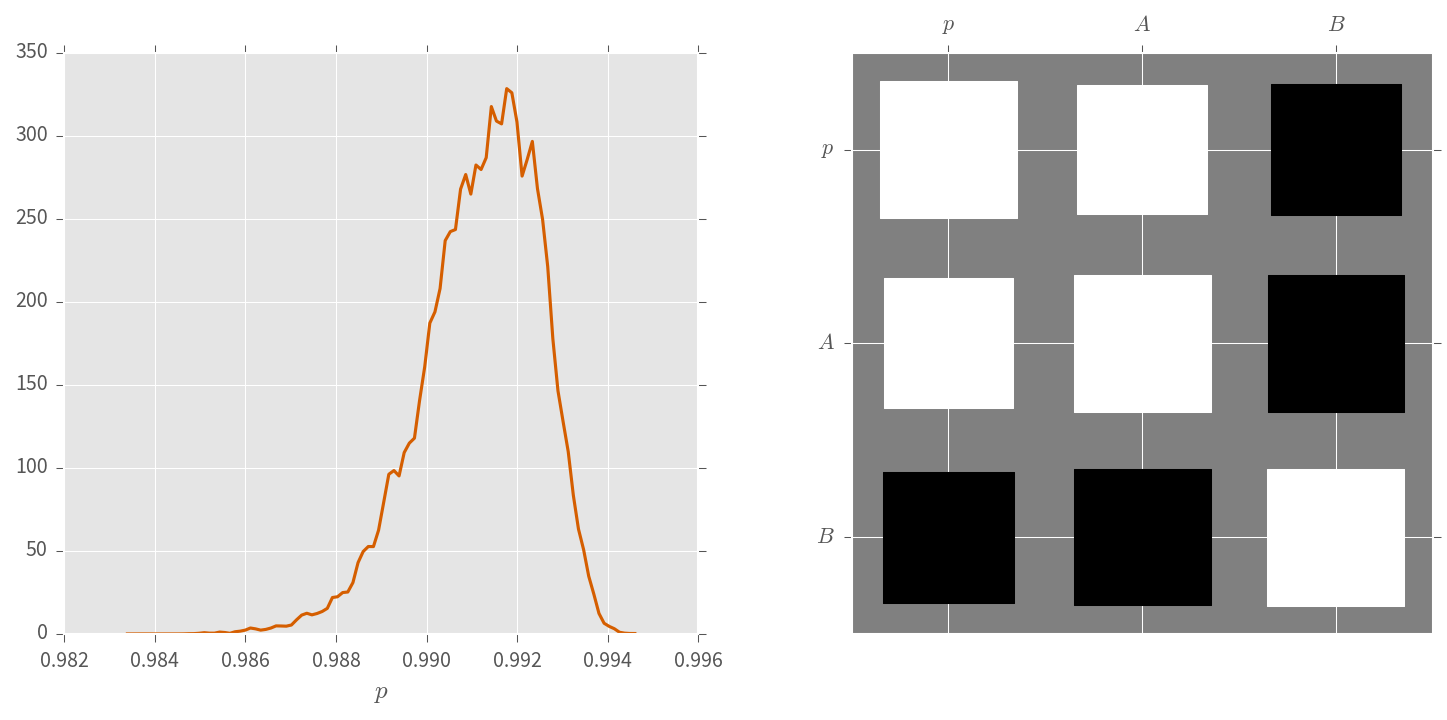

In [97]:
mean, cov, extra = qi.simple_est_rb(data_csv, p_min=0.8, return_all=True)


In [102]:
print(mean[0], "±", np.sqrt(cov)[0, 0])

0.991188359708 ± 0.0012933975599


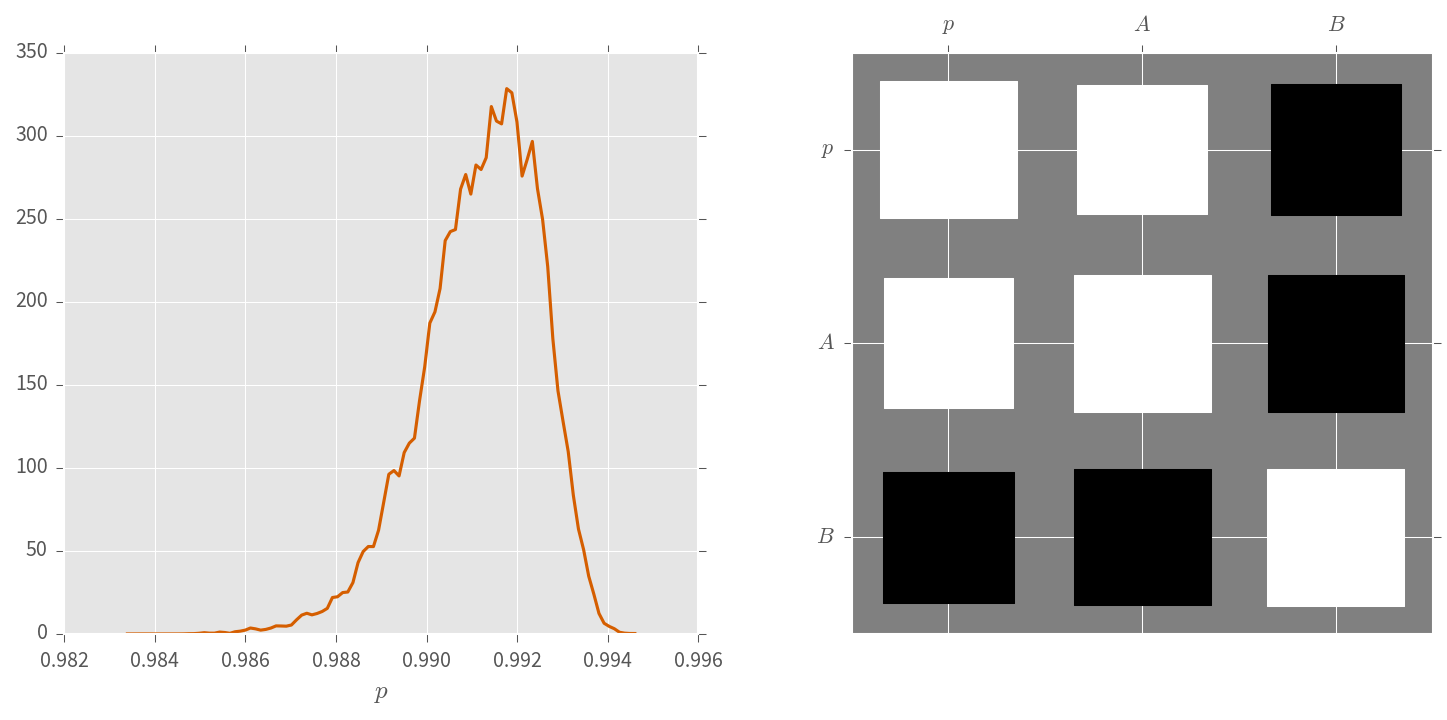

In [98]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
extra['updater'].plot_posterior_marginal(idx_param=0)

plt.subplot(1, 2, 2)
extra['updater'].plot_covariance(corr=True)
plt.savefig('figures/rb-combined.png', format='png', dpi=300, frameon=False, transparent=False)

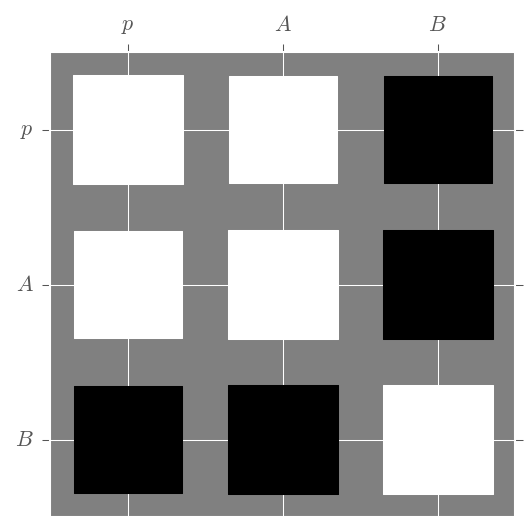

In [91]:
extra['updater'].plot_covariance(corr=True)
plt.savefig('figures/rb-corr.png', format='png', dpi=300, frameon=False, transparent=True)